In [292]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot
import math

In [293]:
tsData = pd.read_csv('MSFT.csv', index_col='Date', parse_dates=True)
tsData = tsData['Adj Close']
tsData = tsData.dropna()
print(tsData)

Date
2017-09-01     69.787331
2017-09-05     69.475868
2017-09-06     69.277672
2017-09-07     70.164894
2017-09-08     69.825096
                 ...    
2022-02-18    287.929993
2022-02-22    287.720001
2022-02-23    280.269989
2022-02-24    294.589996
2022-02-25    297.309998
Name: Adj Close, Length: 1129, dtype: float64


Plotting the time series chart of MSFT Stock Price

(1129,)


<AxesSubplot:xlabel='Date'>

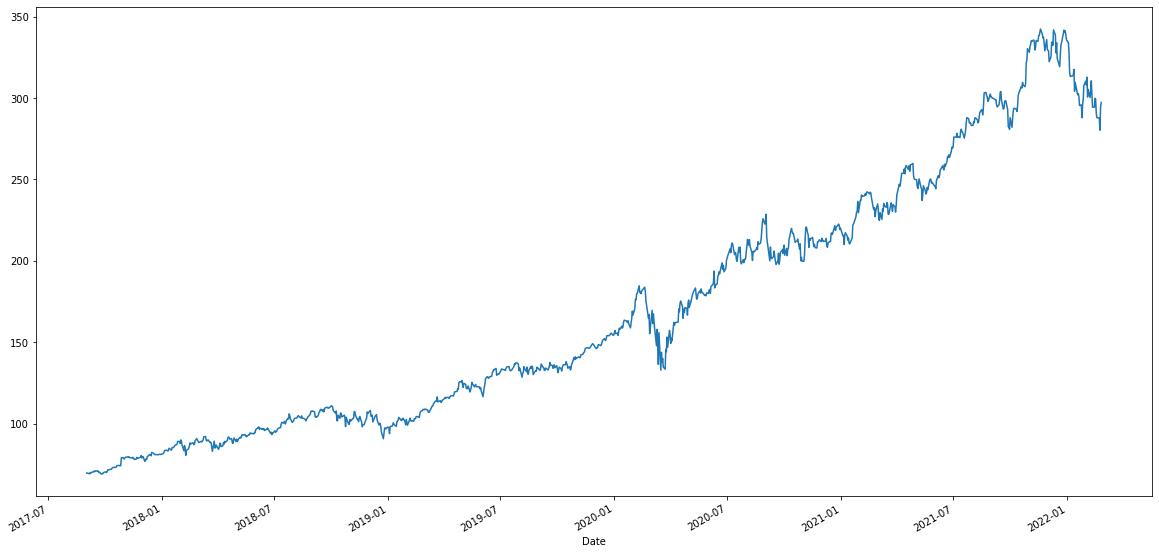

In [294]:
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print(tsData.shape)
tsData.plot()

Seasonal Decompotion to obtain trend

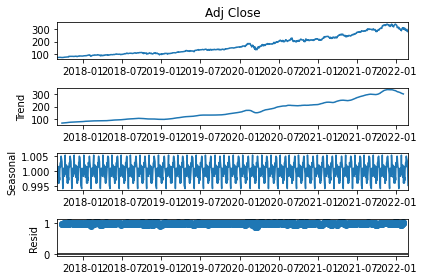

<Figure size 1440x720 with 0 Axes>

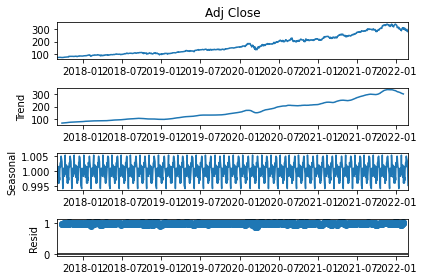

In [295]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

decomposedData = seasonal_decompose(tsData, model='multiplicative', period=30)
decomposedData.plot()

<AxesSubplot:xlabel='Date'>

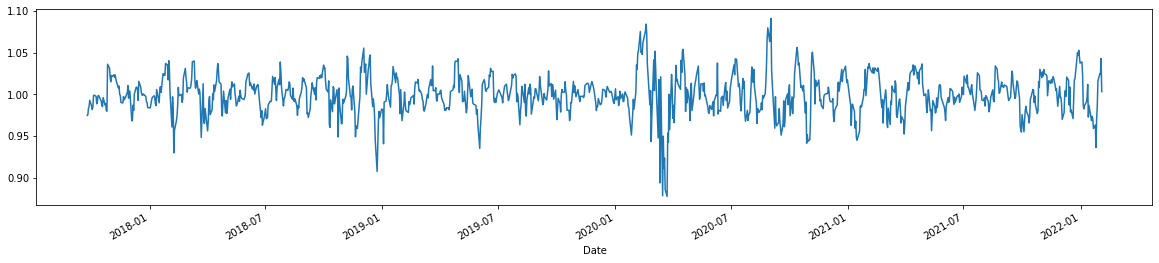

In [296]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(4)
decomposedData.resid.plot()

1129


<AxesSubplot:xlabel='Date'>

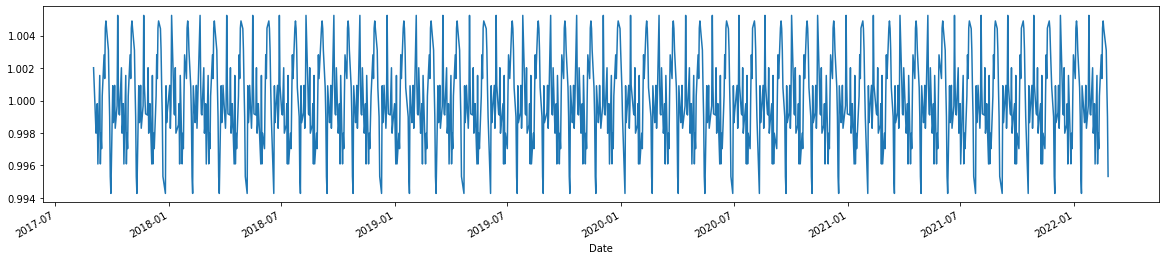

In [297]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(4)
print(decomposedData.seasonal.size)
decomposedData.seasonal.plot()

In [298]:
from statsmodels.tsa.arima.model import ARIMA

train = tsData.iloc[: -10]
test = tsData.iloc[-10 :]
print(train.shape, test.shape)
print('Training Data', train)
print('Testing Data', test)

(1119,) (10,)
Training Data Date
2017-09-01     69.787331
2017-09-05     69.475868
2017-09-06     69.277672
2017-09-07     70.164894
2017-09-08     69.825096
                 ...    
2022-02-04    305.308716
2022-02-07    300.329010
2022-02-08    303.931549
2022-02-09    310.567810
2022-02-10    301.756073
Name: Adj Close, Length: 1119, dtype: float64
Testing Data Date
2022-02-11    294.431213
2022-02-14    294.391296
2022-02-15    299.850006
2022-02-16    299.500000
2022-02-17    290.730011
2022-02-18    287.929993
2022-02-22    287.720001
2022-02-23    280.269989
2022-02-24    294.589996
2022-02-25    297.309998
Name: Adj Close, dtype: float64


Autocorrelation Test on MSFT data (Durbin Watson)

In [299]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS

def DWtest(data):

    plot_acf(data)
    pyplot.show()

    model1 = sm.OLS(data, np.ones(len(data))).fit()
    autoCorr = durbin_watson(model1.resid)
    print('DW Autocorrelation: ', autoCorr)

    if autoCorr == 2:
        print('No autocorrelation')
    elif autoCorr > 1.5 and autoCorr < 2:
        print('Low Positive autocorrelation')
    elif autoCorr >= 0 and autoCorr <= 1.5:
        print('High Positive Autocorrelation')
    elif autoCorr > 2 and autoCorr < 2.5:
        print('Low Negative autocorrelation')
    elif autoCorr >= 2.5 and autoCorr < 4:
        print('High Negative Autocorrelation')  

<Figure size 1440x288 with 0 Axes>

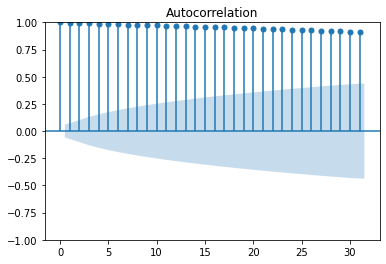

DW Autocorrelation:  0.0017532281941396411
High Positive Autocorrelation


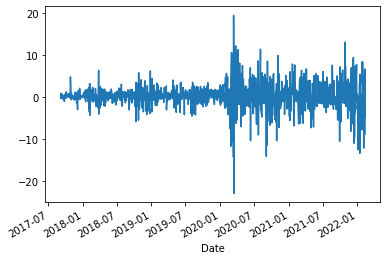

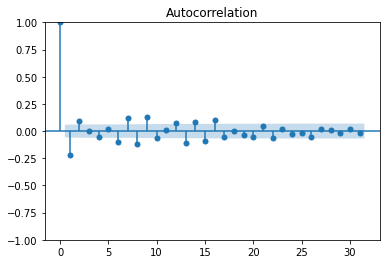

DW Autocorrelation:  2.4240310406055023
Low Negative autocorrelation


In [300]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(4)

DWtest(train)

diff_tsData = train.diff()
diff_tsData = diff_tsData.dropna()
diff_tsData.plot()

DWtest(diff_tsData)

Augmented Dickey Fuller Test Function

In [301]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(data):
    ST = adfuller(data, autolag = 'AIC')
    print('ADF: ', ST[0])
    print('P-value: ', ST[1])
    print('No. of Lags: ', ST[2])
    print('No. of observations used: ', ST[3])
    print('Critical Values: ')
    for item, value in ST[4].items():
        print('\t', item, ': ', value)
    
    return ST[1]

Stationarity Test (ADF)

In [302]:
print('ADF Test for dataset\n')
Stationarity_res = ADF_test(train)

if Stationarity_res > 0.05 :
    print('\nThe given dataset does not reject H0 hypothesis, hence is non-stationary.')
else:
    print('\nThe given dataset rejects H0 hypothesis, hence is stationary.')

ADF Test for dataset

ADF:  0.07391596920242587
P-value:  0.9642344271450396
No. of Lags:  13
No. of observations used:  1105
Critical Values: 
	 1% :  -3.4362817248910282
	 5% :  -2.8641591533631945
	 10% :  -2.5681645177207675

The given dataset does not reject H0 hypothesis, hence is non-stationary.


In [303]:
print('ADF Test for differenced dataset\n')
Stationarity_res = ADF_test(diff_tsData)

if Stationarity_res > 0.05 :
    print('\nThe given dataset does not reject H0 hypothesis, hence is non-stationary.')
else:
    print('\nThe given dataset rejects H0 hypothesis, hence is stationary.')

ADF Test for differenced dataset

ADF:  -9.394264061485925
P-value:  6.437281480420823e-16
No. of Lags:  12
No. of observations used:  1105
Critical Values: 
	 1% :  -3.4362817248910282
	 5% :  -2.8641591533631945
	 10% :  -2.5681645177207675

The given dataset rejects H0 hypothesis, hence is stationary.


Obtain parameters of ARIMA model

In [304]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

AIC_result = auto_arima(train, trace=True, suppress_warnings=True, seasonal=True, max_order=(3,3,3))
AIC_result.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5715.356, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5765.595, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5714.023, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5720.728, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5768.336, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5713.520, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5714.353, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5715.181, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5714.235, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5703.228, Time=0.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5714.020, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5681.721, Time=0.78 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5702.175, Time=1.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5713.482, Time=1.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1119
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -2833.861
Date:                Tue, 01 Mar 2022   AIC                           5681.721
Time:                        00:24:06   BIC                           5716.856
Sample:                             0   HQIC                          5695.003
                               - 1119                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8317      0.322      2.585      0.010       0.201       1.462
ar.L1         -1.8373      0.053    -34.487      0.000      -1.942      -1.733
ar.L2         -1.0561      0.074    -14.247      0.000      -1.201      -0.911
ar.L3         -0.0800      0.029     -2.794      0.005      -0.136      -0.024
ma.L1          1.6606      0.048     34.586      0.000       1.567       1.755
ma.L2          0.7978      0.047     16.866      0.000       0.705       0.890
sigma2         9.3123      0.228     40.768      0.000       8.865       9.760
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1060.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.55   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model ARIMA(3,1,2)

Training of ARIMA Model

In [305]:
model = ARIMA(train, order=(3,1,2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1119
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2837.297
Date:                Tue, 01 Mar 2022   AIC                           5686.595
Time:                        00:24:06   BIC                           5716.710
Sample:                             0   HQIC                          5697.978
                               - 1119                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8264      0.053    -34.565      0.000      -1.930      -1.723
ar.L2         -1.0399      0.074    -14.131      0.000      -1.184      -0.896
ar.L3         -0.0718      0.028     -2.532      0.011      -0.127      -0.016
ma.L1          1.6558      0.048     34.702      0.000       1.562       1.749
ma.L2          0.7954      0.047     16.835      0.000       0.703       0.888
sigma2         9.3697      0.230     40.820      0.000       8.920       9.820
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1070.99
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               6.56   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Testing of ARIMA Model

In [306]:
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start=start, end=end)
predictions.index = test.index
for num in range(len(predictions)):
    print('Pred: ', predictions[num], ' Actual: ', test[num])

Pred:  305.247789633383  Actual:  294.431213
Pred:  302.15183108237693  Actual:  294.391296
Pred:  304.8075785827565  Actual:  299.850006
Pred:  302.9260364284111  Actual:  299.5
Pred:  303.8229490618605  Actual:  290.730011
Pred:  303.9508563012856  Actual:  287.929993
Pred:  302.91957641036424  Actual:  287.720001
Pred:  304.60572527410966  Actual:  280.269989
Pred:  302.5893966012313  Actual:  294.589996
Pred:  304.59259705225435  Actual:  297.309998


<AxesSubplot:xlabel='Date'>

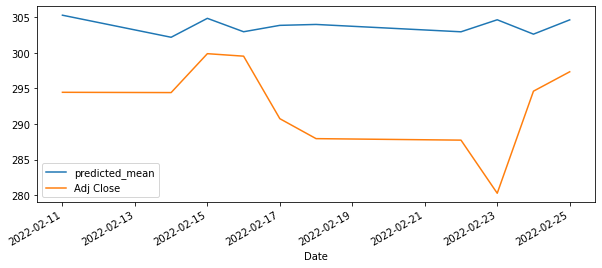

In [307]:
f = plt.figure()
f.set_figwidth(10)

predictions.plot(legend=True)
test.plot(legend=True)

In [308]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mean_test = test.mean()
sq_mse = sqrt(mean_squared_error(predictions, test))
print('Mean: ', mean_test, ' and MSE: ', sq_mse)
print('Percentage error: ', 100*sq_mse/mean_test)

Mean:  292.6722503000001  and MSE:  12.5774178031748
Percentage error:  4.2974411787528455


<AxesSubplot:xlabel='Date'>

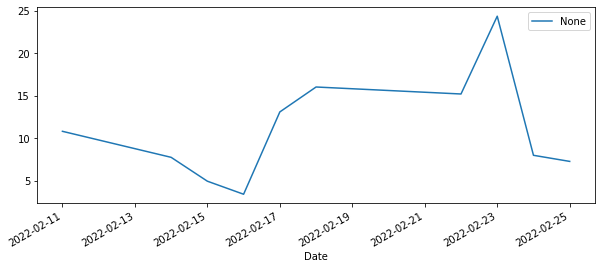

In [309]:
residuals = predictions - test
f = plt.figure()
f.set_figwidth(10)

residuals.plot(legend=True)